In [ ]:
import sys
!{sys.executable} -m pip install pygraphviz

<div style='text-align:center;'>
    <h1>HopSurfer in BioPortal</h1>
</div>

<h2>Dependencies</h2>

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import os
import graphviz
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from scipy.io import mmread
import scipy.sparse as sparse
from scipy.sparse import diags
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv
from collections import defaultdict
from sklearn.preprocessing import normalize
from networkx.drawing.nx_agraph import to_agraph


<h2>Functions and Methods</h2>

In [2]:
##############################################################################
# AIC
##############################################################################
def AIC(loglikelihood, params, observations):
    if observations/params > 40:
        return (-2 * loglikelihood) + (2 * params) + ((2*params*(params+1))/(observations-params-1))
    return (-2 * loglikelihood) + (2 * params)

def BIC(loglikelihood, params, observations):
    return (-2 * loglikelihood) + (params * np.log(observations))

In [3]:
##############################################################################
# RANDOM WALK
##############################################################################

def random_walk_likelihood(structure, transitions, alpha=0.85):
    params = []
    if alpha is not None and (alpha < 0 or alpha > 1):
        raise ValueError("damping factor must be between 0 and 1 (inclusive).")
        return None, None

    params = [alpha]
    N = structure.shape[0]
    
    if alpha > 0:
        
        if alpha == 1.0:
            alpha = 0.99999
            
        ### random walk
        P = csr_matrix(alpha * normalize(structure, norm='l1', axis=0))
        T = csr_matrix( (np.ones((N,N))*(1-alpha)) / N )
        P = csr_matrix(P + T)
    else:
        ### always random jump (teleportation)
        P = csr_matrix(np.ones((N,N)) / N)
        
    ### log-likelihood
    l = (transitions.toarray() * np.log(P.toarray())).sum()
    return l,params

In [4]:
##############################################################################
# HOP RANK
##############################################################################

def hop_counts(structure):
    hops = csr_matrix(structure.shape, dtype=np.int16)
    previous_hops = None
    
    hop = 1
    structure.setdiag(0)
    m = structure.copy()

    for r,row in enumerate(structure):
        hops[r,row.indices] = hop
        
    while m.sum() > 0:
        
        if previous_hops is None:
            previous_hops = m.copy()
        else:
            previous_hops += m
    
        m = lil_matrix(m.dot(structure))
        m.setdiag(0)
        m -= previous_hops
        m = (m>0).astype(np.int8)
        m.eliminate_zeros()
        
        hop += 1
        for r,row in enumerate(m):
            hops[r,row.indices] = hop

    hops.setdiag(0) 
    return hops

def hop_alphas(transitions, hops):    
    maxhops = int(hops.max()) 
    total = transitions.sum() + maxhops + 1
    alphas = np.zeros(maxhops + 1)
    counts = np.zeros(maxhops + 1)
    
    for hop in range(maxhops+1):
        if hop == 0:
            counts[hop] = 1 # for selfloops
        else:
            transitions_in_hop = np.any(hops==hop).astype(np.int8).multiply(transitions)
            counts[hop] = transitions_in_hop.sum() + 1
        alphas[hop] = counts[hop] / total
        
    return alphas, counts

def hop_surfer_likelihood_1(structure, transitions, hops=None, alphas=None):
    
    # ALPHA / Ni (normalized row)
    
    if hops is None:
        hops = hop_counts(structure) # k-hop matrix
    
    if alphas is None:
        alphas, counts = hop_alphas(transitions, hops)
        
    P = None
    N = structure.shape[0]

    for hop, alpha in enumerate(alphas):
        m = csr_matrix(np.isin(hops.toarray(),[hop],assume_unique=False).astype(np.int8) * alpha)        
        if hop == 0:
            P = csr_matrix(normalize(m, norm='l1', axis=1))
        else:
            P += csr_matrix(normalize(m, norm='l1', axis=1))

            
    l = (transitions.toarray() * np.log(P.toarray())).sum()
    return l,alphas


def hop_surfer_likelihood_2(structure, transitions, hops=None, alphas=None):
    
    # ALPHA * STOCH. ADJ.
    
    if hops is None:
        hops = hop_counts(structure) # k-hop matrix
    
    if alphas is None:
        alphas, counts = hop_alphas(transitions, hops)
        
    P = None
    N = structure.shape[0]

    for hop, alpha in enumerate(alphas):
        m = csr_matrix(np.isin(hops.toarray(),[hop],assume_unique=False).astype(np.int8))        
        if hop == 0:
            P = csr_matrix(alpha * normalize(m, norm='l1', axis=1))
        else:
            P += csr_matrix(alpha * normalize(m, norm='l1', axis=1))
    
    l = (transitions.toarray() * np.log(P.toarray())).sum()
    return l,alphas


def hop_surfer_likelihood_3(structure, transitions, hops=None, alphas=None):
    
    # DEGREE 0 * ALPHA * M
    if hops is None:
        hops = hop_counts(structure) # k-hop matrix
    
    if alphas is None:
        alphas, counts = hop_alphas(transitions, hops)
        
    P = None
    N = structure.shape[0]

    for hop, alpha in enumerate(alphas):            
        m = csr_matrix(np.isin(hops.toarray(),[hop],assume_unique=False).astype(np.int8))        
        if hop == 0:
            P = csr_matrix(alpha * normalize(m, norm='l1', axis=1))
        else:
            P += csr_matrix(alpha * normalize(m, norm='l1', axis=1))
   
    P = csr_matrix( np.multiply(P.toarray(), np.repeat(structure.sum(axis=0), N, axis=0) ) )
    
    l = (transitions.toarray() * np.log(P.toarray())).sum()
    return l,alphas


def hop_surfer_likelihood_4(structure, transitions, hops=None, alphas=None):
    
    # DEGREE j * ALPHA * M
    if hops is None:
        hops = hop_counts(structure) # k-hop matrix
    
    if alphas is None:
        alphas, counts = hop_alphas(transitions, hops)
        
    P = None
    N = structure.shape[0]

    for hop, alpha in enumerate(alphas):            
        m = csr_matrix(np.isin(hops.toarray(),[hop],assume_unique=False).astype(np.int8))        
        if hop == 0:
            P = csr_matrix(alpha * normalize(m, norm='l1', axis=1))
        else:
            P += csr_matrix(alpha * normalize(m, norm='l1', axis=1))
   
    P = csr_matrix( np.multiply(P.toarray(), np.repeat(structure.sum(axis=1), N, axis=1) ) )
    
    l = (transitions.toarray() * np.log(P.toarray())).sum()
    return l,alphas


def hop_surfer_likelihood_5(structure, transitions, hops=None, alphas=None):
    
    # DEGREE * DEGREE * ALPHA * M
    
    if hops is None:
        hops = hop_counts(structure) # k-hop matrix
    
    if alphas is None:
        alphas, counts = hop_alphas(transitions, hops)
        
    P = None
    N = structure.shape[0]

    for hop, alpha in enumerate(alphas):            
        m = csr_matrix(np.isin(hops.toarray(),[hop],assume_unique=False).astype(np.int8))        
        if hop == 0:
            P = csr_matrix(alpha * normalize(m, norm='l1', axis=1))
        else:
            P += csr_matrix(alpha * normalize(m, norm='l1', axis=1))
   
    P = csr_matrix( np.multiply(P.toarray(), np.multiply(np.repeat(structure.sum(axis=1), N, axis=1), np.repeat(structure.sum(axis=0), N, axis=0)) ) )
    
    l = (transitions.toarray() * np.log(P.toarray())).sum()
    return l,alphas


def hop_surfer_likelihood_6(structure, transitions, hops=None, alphas=None):
    
    # DISTANCE^-1 * DEGREE * DEGREE * ALPHA * M
    
    if hops is None:
        hops = hop_counts(structure) # k-hop matrix
    
    if alphas is None:
        alphas, counts = hop_alphas(transitions, hops)
        
    P = None
    N = structure.shape[0]

    for hop, alpha in enumerate(alphas):            
        m = csr_matrix(np.isin(hops.toarray(),[hop],assume_unique=False).astype(np.int8))        
        if hop == 0:
            P = csr_matrix(alpha * normalize(m, norm='l1', axis=1))
        else:
            P += csr_matrix(alpha * normalize(m, norm='l1', axis=1))
   
    tmp = hops.toarray()
    tmp[tmp==0]= tmp.max()+1
    np.fill_diagonal(tmp,tmp.max()+1)    
    tmp = 1/(tmp+1)
    
    P = csr_matrix( np.multiply(P.toarray(), np.multiply( tmp, np.multiply(np.repeat(structure.sum(axis=1), N, axis=1), np.repeat(structure.sum(axis=0), N, axis=0)) ) ) )
    
    l = (transitions.toarray() * np.log(P.toarray())).sum()
    return l,alphas



def load_hop_counts(path,ontology,year):
    
    hops = None #csr_matrix(structure.shape, dtype=np.int16)
    
    for fn in os.listdir(path):        
        if fn.endswith('HOP.mtx') and fn.startswith('{}_{}_'.format(ontology,year)):
            hop = int(fn.split('_')[2].replace('HOP.mtx',''))
            m = mmread(os.path.join(path,fn))            
            m = m * hop
            
            if hops is None:
                hops = m.copy()
            else:
                hops = hops + m
    return hops

In [5]:
##############################################################################
# MARKOV CHAIN
##############################################################################

def markov_chain_likelihood(structure, transitions):
    P = normalize(transitions,'l1',axis=1)
    l = (transitions.data * np.log(P.data)).sum()
    
    params = sparse.find(P.tocsr())[2].tolist()
    return l,params

In [6]:
##############################################################################
# VIZ
##############################################################################

def plot_graph(G, title, ax=None, pos=None, small=False):
    
    if small:
        ns = 50
        fs = 5
    else:
        ns = 700
        fs = 20
        
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(3,3))
        
    if pos is None:
        pos = nx.spring_layout(G)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=ns, ax=ax)

    # edges
    edges = [(u, v, d) for (u, v, d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for (u, v, d) in edges], width=[d['weight'] if 'weight' in d else 2 for (u, v, d) in edges], ax=ax)

    # labels
    nx.draw_networkx_labels(G, pos, font_size=fs, font_family='sans-serif', ax=ax)

    ax.axis('off')
    ax.set_title(title.upper())
    return pos


##############################################################################
# HANDLERS
##############################################################################

def weighted_to_undirected(G):
    tmp = nx.Graph()
    tmp.add_edges_from(G.edges(), weight=0)
    for u, v, d in G.edges(data=True):
        tmp[u][v]['weight'] += d['weight']
    return tmp


<div style='text-align:center;'>
<h1>Toy-Example</h1>
</div>

<h2>Datasets</h2>

In [7]:
##############################################################################
# DATA: AS GRAPHS
##############################################################################

### STRUCTURE
G=nx.DiGraph()
G.add_edge('a','b')
G.add_edge('a','c')
G.add_edge('b','d')
G.add_edge('b','e')
G.add_edge('c','f')
G.add_edge('c','g')

### TRANSITIONS
H=nx.DiGraph()
H.add_edge('b','d',weight=1)
H.add_edge('d','e',weight=10)
H.add_edge('e','g',weight=5)

### TO UNDIRECTED
H = weighted_to_undirected(H)

### ADJACENCY MATRICES
S = nx.adjacency_matrix(G.to_undirected(),['a','b','c','d','e','f','g'])
T = nx.adjacency_matrix(H,['a','b','c','d','e','f','g'])

<h2>Experiments and Results</h2>

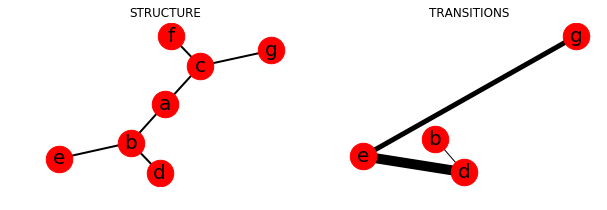

In [8]:
##############################################################################
# Data Vizualization
##############################################################################
fig, axes = plt.subplots(1,2,figsize=(10,3))
pos = plot_graph(G.to_undirected(),title='structure',ax=axes[0],pos=None,small=False)
_ = plot_graph(H,title='transitions',ax=axes[1],pos=pos,small=False)

In [9]:
##############################################################################
# LOG-LIKELIHOODS
##############################################################################

columns = ['method','n-params','likelihood','aic']
df = pd.DataFrame(columns=columns)

### RANDOM
alpha = 0.0
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('RANDOM: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(l,aic,bic))
df = df.append({'method':'Random', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### STRUCTURE
alpha = 1.0
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('STRUCTURE: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(l,aic,bic))
df = df.append({'method':'Structure', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### PAGERANK
alpha = 0.85
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('PAGERANK: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(l,aic,bic))
df = df.append({'method':'PageRank', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### MARKOV CHAIN
l,params = markov_chain_likelihood(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('MARKOV CHAIN {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(len(params),l,aic,bic))
df = df.append({'method':'Markov Chain', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 1
l,params = hop_surfer_likelihood_1(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 1 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 1', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 2
l,params = hop_surfer_likelihood_2(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 2 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 2', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 3
l,params = hop_surfer_likelihood_3(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 3 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 3', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 4
l,params = hop_surfer_likelihood_4(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 4 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 4', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 5
l,params = hop_surfer_likelihood_5(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 5 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 5', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 6
l,params = hop_surfer_likelihood_6(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 6 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 6', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

RANDOM: 
- likelihood: -62.26912476977003
- AIC: 126.53824953954006
- BIC: 126.48415968859537

STRUCTURE: 
- likelihood: -404.8636949953383
- AIC: 811.7273899906766
- BIC: 811.6733001397319

PAGERANK: 
- likelihood: -116.61674984346968
- AIC: 235.23349968693935
- BIC: 235.17940983599468

MARKOV CHAIN 6: 
- likelihood: -12.898709595263814
- AIC: 37.79741919052763
- BIC: 37.472880084859504

HOPSURFER 1 [0.02631579 0.05263158 0.55263158 0.05263158 0.28947368 0.02631579]: 
- likelihood: -12.08473517534921
- AIC: 36.16947035069842
- BIC: 35.844931245030295

HOPSURFER 2 [0.02631579 0.05263158 0.55263158 0.05263158 0.28947368 0.02631579]: 
- likelihood: -42.231796443021494
- AIC: 96.46359288604299
- BIC: 96.13905378037487

HOPSURFER 3 [0.02631579 0.05263158 0.55263158 0.05263158 0.28947368 0.02631579]: 
- likelihood: -41.13318415435339
- AIC: 94.26636830870677
- BIC: 93.94182920303865

HOPSURFER 4 [0.02631579 0.05263158 0.55263158 0.05263158 0.28947368 0.02631579]: 
- likelihood: -41.13318415

/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


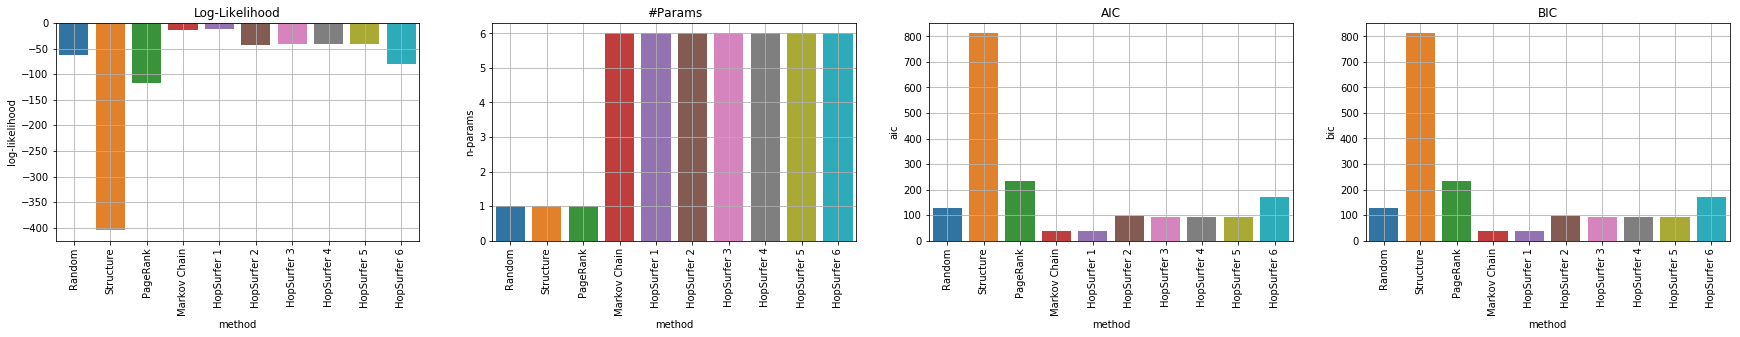

In [10]:
fig,axes = plt.subplots(1,4,figsize=(30,4))
_ = sns.barplot(data=df, x='method',y='log-likelihood',ax=axes[0])
_ = sns.barplot(data=df, x='method',y='n-params',ax=axes[1])
_ = sns.barplot(data=df, x='method',y='aic',ax=axes[2])
_ = sns.barplot(data=df, x='method',y='bic',ax=axes[3])

axes[0].set_title('Log-Likelihood')
axes[1].set_title('#Params')
axes[2].set_title('AIC')
axes[3].set_title('BIC')

for ax in axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.grid()

<div style='text-align:center;'>
<h1>BioPortal</h1>
</div>

<h2>Datasets</h2>

In [11]:
ONTO = 'ICPC'
Y = '2015'
TYPE = 'ALL'
G = nx.read_adjlist('/bigdata/lespin/bioportal/ontologies/graph/{}_{}.adjlist'.format(ONTO,Y), create_using=nx.DiGraph())
H = nx.read_weighted_edgelist('/bigdata/lespin/bioportal/clickstreams/graph/{}/{}_{}.adjlist'.format(TYPE,ONTO,Y), create_using=nx.DiGraph())
H = weighted_to_undirected(H)

allnodes = sorted(list(G.nodes()))
tmp = list(set(list(max(nx.connected_components(G.to_undirected()), key=len))).intersection(set(list(H.nodes()))))
nodes=[]
sg = G.subgraph(tmp)
for n in tmp:
    if sg.degree(n) > 0:
        nodes.append(n)
sg = G.subgraph(nodes)

S = nx.adjacency_matrix(G.to_undirected(),nodes)
T = nx.adjacency_matrix(H,nodes)
hops = load_hop_counts('/bigdata/lespin/bioportal/ontologies/hops',ONTO,Y)

mask = np.isin(allnodes,nodes)
hops = hops[mask,:]
hops = hops[:,mask]

S.shape, T.shape, hops.shape

((158, 158), (158, 158), (158, 158))

<h2>Experiments and Results</h2>

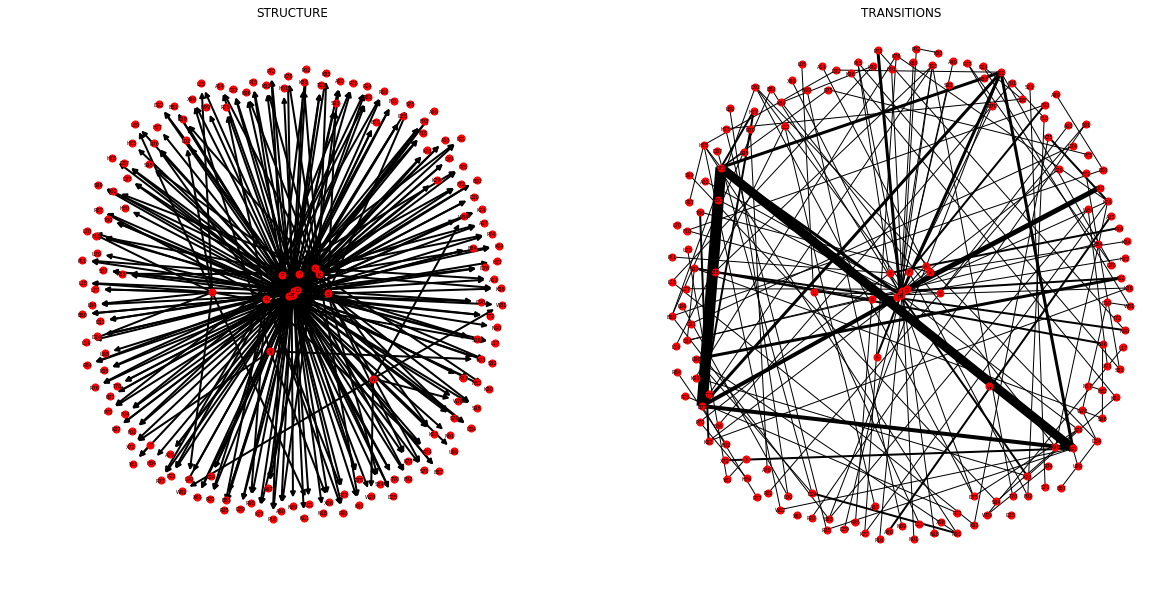

In [12]:
##############################################################################
# Data Vizualization
##############################################################################
fig, axes = plt.subplots(1,2,figsize=(20,10))
# pos = plot_graph(G,title='original',ax=axes[0],pos=None,small=True)
pos = plot_graph(sg,title='structure',ax=axes[0],pos=None,small=True)
_ = plot_graph(H.subgraph([n for n in nodes if n in nodes]),title='transitions',ax=axes[1],pos=pos,small=True)

In [15]:
##############################################################################
# LOG-LIKELIHOODS
##############################################################################

columns = ['method','n-params','likelihood','aic']
df = pd.DataFrame(columns=columns)

### RANDOM
alpha = 0.0
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('RANDOM: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(l,aic,bic))
df = df.append({'method':'Random', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### STRUCTURE
alpha = 1.0
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('STRUCTURE: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(l,aic,bic))
df = df.append({'method':'Structure', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### PAGERANK
alpha = 0.85
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('PAGERANK: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(l,aic,bic))
df = df.append({'method':'PageRank', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### MARKOV CHAIN
l,params = markov_chain_likelihood(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('MARKOV CHAIN {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(len(params),l,aic,bic))
df = df.append({'method':'Markov Chain', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 1
l,params = hop_surfer_likelihood_1(S,T,hops)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 1 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 1', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 2
l,params = hop_surfer_likelihood_2(S,T,hops)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 2 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 2', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 3
l,params = hop_surfer_likelihood_3(S,T,hops)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 3 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 3', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 4
l,params = hop_surfer_likelihood_4(S,T,hops)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 4 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 4', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 5
l,params = hop_surfer_likelihood_5(S,T,hops)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 5 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 5', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER 6
l,params = hop_surfer_likelihood_6(S,T,hops)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPSURFER 6 {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopSurfer 6', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

RANDOM: 
- likelihood: -2217.4166244658113
- AIC: 4436.858889957263
- BIC: 4439.895843964649

STRUCTURE: 
- likelihood: -5399.471088766271
- AIC: 10800.967818558183
- BIC: 10804.00477256557

PAGERANK: 
- likelihood: -2435.8570583045985
- AIC: 4873.739757634838
- BIC: 4876.776711642224

MARKOV CHAIN 324: 
- likelihood: -495.92615876913044
- AIC: 1639.8523175382609
- BIC: 2632.133108238998

HOPSURFER 1 [0.00225734 0.0248307  0.53498871 0.09255079 0.34537246]: 
- likelihood: -1871.5436444920308
- AIC: 3753.0872889840616
- BIC: 3768.4002641491966

HOPSURFER 2 [0.00225734 0.0248307  0.53498871 0.09255079 0.34537246]: 
- likelihood: -2312.9166110161027
- AIC: 4635.833222032205
- BIC: 4651.14619719734

HOPSURFER 3 [0.00225734 0.0248307  0.53498871 0.09255079 0.34537246]: 
- likelihood: -1815.2959187624047
- AIC: 3640.5918375248093
- BIC: 3655.9048126899443

HOPSURFER 4 [0.00225734 0.0248307  0.53498871 0.09255079 0.34537246]: 
- likelihood: -1815.2959187624047
- AIC: 3640.5918375248093
- BIC:

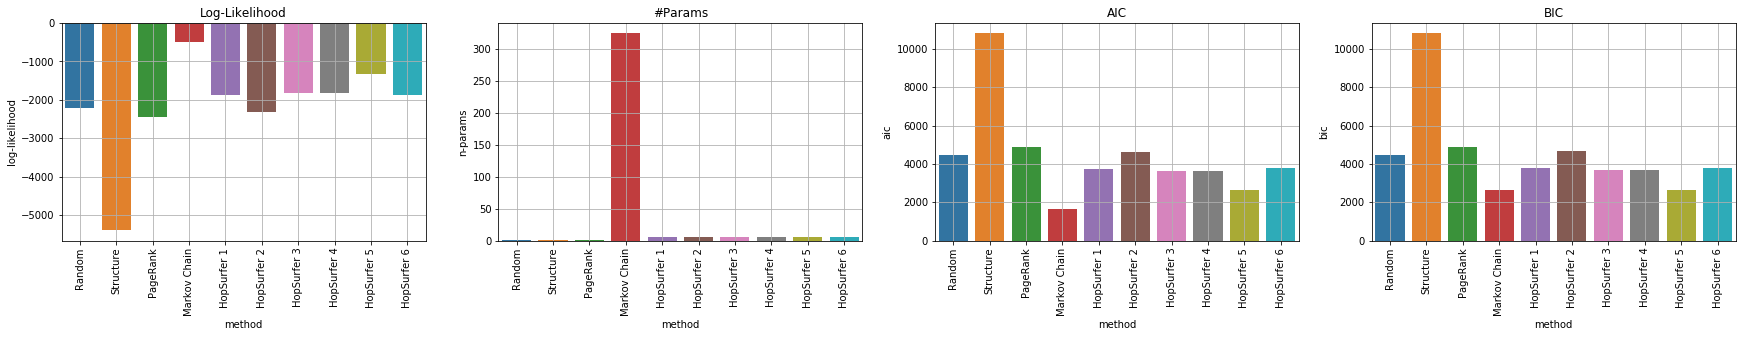

In [16]:
fig,axes = plt.subplots(1,4,figsize=(30,4))
_ = sns.barplot(data=df, x='method',y='log-likelihood',ax=axes[0])
_ = sns.barplot(data=df, x='method',y='n-params',ax=axes[1])
_ = sns.barplot(data=df, x='method',y='aic',ax=axes[2])
_ = sns.barplot(data=df, x='method',y='bic',ax=axes[3])

axes[0].set_title('Log-Likelihood')
axes[1].set_title('#Params')
axes[2].set_title('AIC')
axes[3].set_title('BIC')

for ax in axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.grid()